# DEMETER project
As an example, we use daily average hindcast data from the DEMETER project where the results of seven different climate models and nine different sets of simulation parameters each constitute ensembles with 63 members.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import netCDF4 as nc
import nibabel as nib

In [4]:
ds_2 = nc.Dataset('../../Data/DEMETER/netcdf/day20_2meter_temp_C.nc')
ds_200 = nc.Dataset('../../Data/DEMETER/netcdf/day20_200_temp.nc')
ds_500 = nc.Dataset('../../Data/DEMETER/netcdf/day20_500_temp.nc')
ds_850 = nc.Dataset('../../Data/DEMETER/netcdf/day20_850_temp.nc')
heights = [ds_2, ds_200, ds_500, ds_850]
print(ds_2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    history: 2009-05-19 17:02:00 GMT by mars2netcdf-0.92
    dimensions(sizes): longitude(144), latitude(73), number(9), time(1)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 number(number), int32 time(time), int16 cnrm(time, number, latitude, longitude), int16 crfc(time, number, latitude, longitude), int16 lody(time, number, latitude, longitude), int16 scnr(time, number, latitude, longitude), int16 scwf(time, number, latitude, longitude), int16 smpi(time, number, latitude, longitude), int16 ukmo(time, number, latitude, longitude)
    groups: 


# Statistical model of each simulation

In [5]:
simulations = ['cnrm', 'crfc', 'lody', 'scnr', 'scwf', 'smpi', 'ukmo']

models = np.empty((4, len(simulations), ds_2.dimensions['latitude'].size, ds_2.dimensions['longitude'].size, 2))
for height,ds in enumerate(heights):
    for idx,sim in enumerate(simulations):
        ensemble = ds[sim][0]
        mean = np.mean(ensemble, axis=0)
        std = np.std(ensemble, axis=0)

        models[height,idx,:,:,0] = mean
        models[height,idx,:,:,1] = std

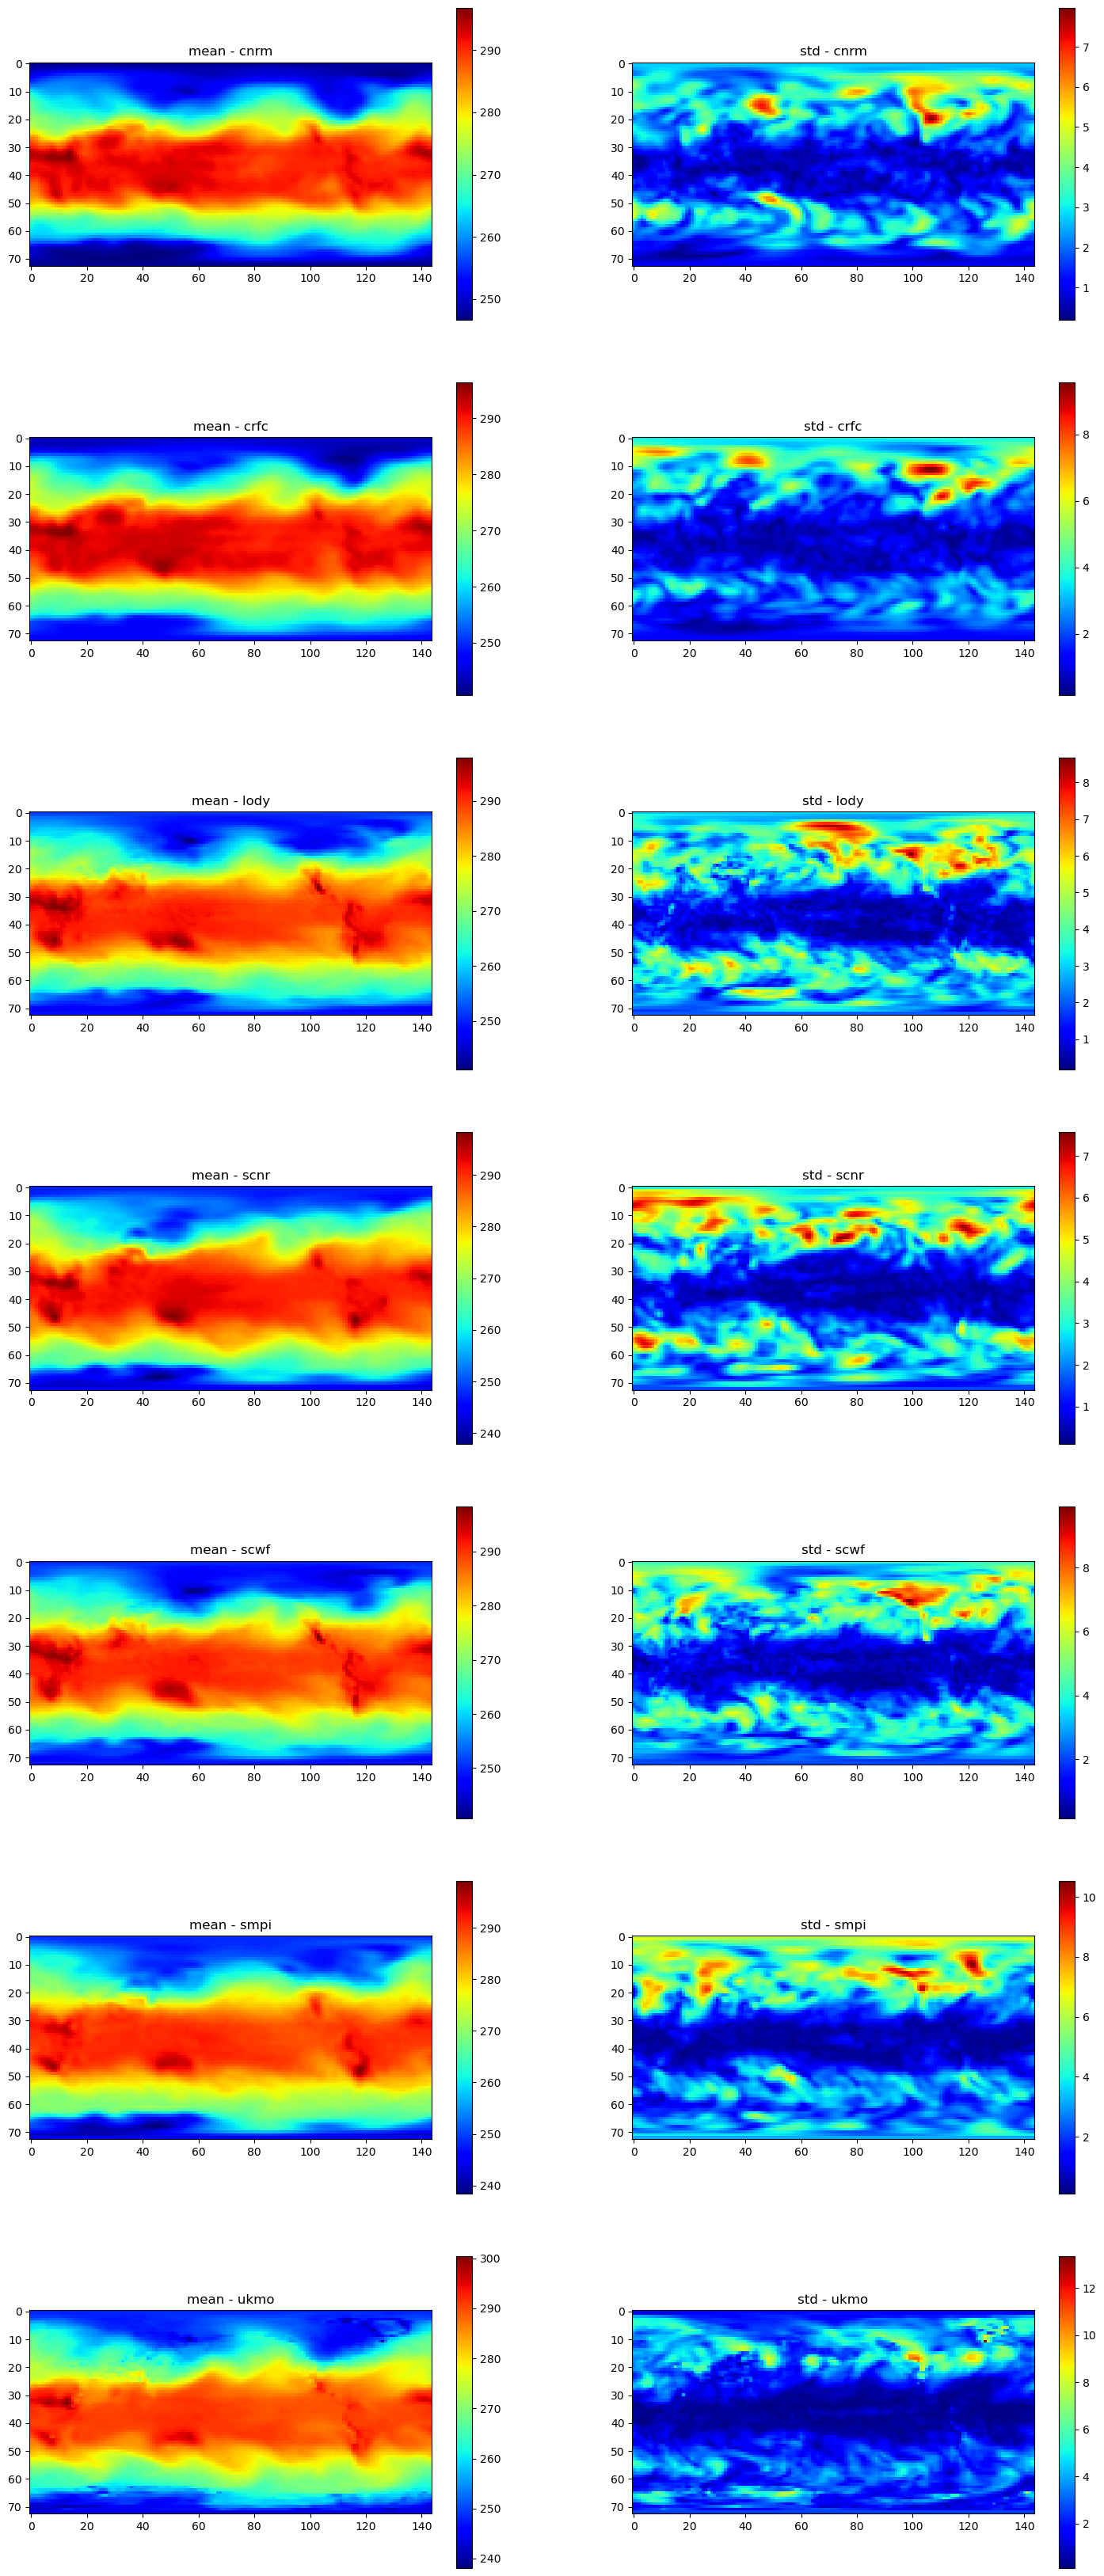

In [6]:
height_idx = 3

plt.figure(figsize=(18,7*6))
for idx,sim in enumerate(simulations):

    plt.subplot(len(simulations), 2, (2*idx)+1)
    plt.title('mean - ' + sim)
    plt.imshow(models[height_idx,idx,:,:,0], cmap='jet')
    plt.colorbar()

    plt.subplot(len(simulations), 2, (2*idx)+2)
    plt.title('std - ' + sim)
    plt.imshow(models[height_idx,idx,:,:,1], cmap='jet')
    plt.colorbar()

plt.show()

# Exporting each model

In [17]:
for idx,sim in enumerate(simulations):
    mean = np.transpose(models[:,idx,:,:,0], [1,2,0])
    std = np.transpose(models[:,idx,:,:,1], [1,2,0])
    mean.tofile('../../Data/DEMETER/' + sim + '-mean.raw')
    std.tofile('../../Data/DEMETER/' + sim + '-std.raw')

    affine = np.eye(4)
    affine[2,2] = 10

    nii_mean = nib.Nifti1Image(mean.astype(np.float64), affine)
    nib.save(nii_mean, '../../Data/DEMETER/' + sim + '-mean.nii')
    nii_std = nib.Nifti1Image(std.astype(np.float64), affine)
    nib.save(nii_std, '../../Data/DEMETER/' + sim + '-std.nii')

# Combined model

In [8]:
combined_model = np.empty((4, len(simulations), ds_2.dimensions['longitude'].size, ds_2.dimensions['latitude'].size, 9))
for height,ds in enumerate(heights):
    for idx,sim in enumerate(simulations):
        ensemble = ds[sim][0]
        
        combined_model[height, idx, :, :, :] = np.transpose(ensemble)

print( combined_model.shape )
combined_model = np.transpose(combined_model, [0, 2, 3, 1, 4])
print( combined_model.shape )

(4, 7, 144, 73, 9)
(4, 144, 73, 7, 9)


In [9]:
mean_combined = np.mean(combined_model.reshape( (*combined_model.shape[:3], -1) ), 3)
variance_combined = np.var(combined_model.reshape( (*combined_model.shape[:3], -1) ), 3)

mean_combined = np.transpose(mean_combined, [2,1,0])
variance_combined = np.transpose(variance_combined, [2,1,0])

print( mean_combined.shape )

(73, 144, 4)


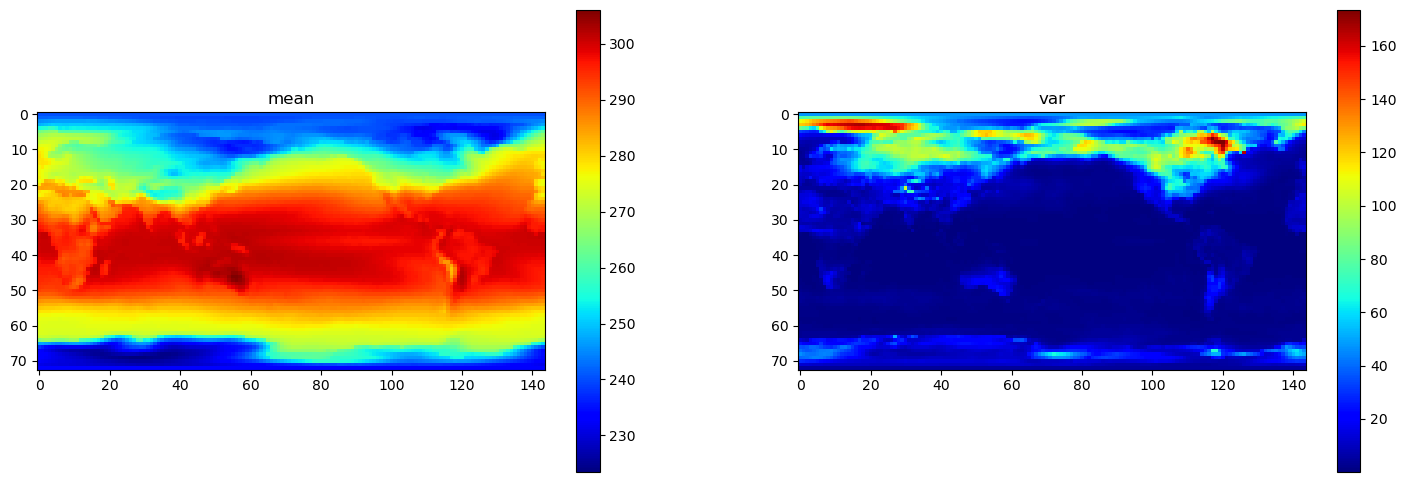

In [10]:
height_idx = 0

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.title('mean')
plt.imshow(mean_combined[...,height_idx], cmap='jet')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('var')
plt.imshow(variance_combined[...,height_idx], cmap='jet')
plt.colorbar()

plt.show()

# Exporting

In [11]:
mean_combined.tofile('../../Data/DEMETER/mean.raw')
variance_combined.tofile('../../Data/DEMETER/variance.raw')